In [35]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import math

In [36]:
# reading the dataset 
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [37]:
# stochastic gradient descent
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [38]:
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.253, 0.017 sec/epoch


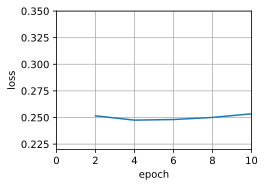

In [39]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr':lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss: 0.243, 0.301 sec/epoch


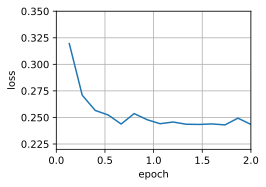

In [40]:
sgd_res = train_sgd(0.005, 1)

loss: 0.242, 0.021 sec/epoch


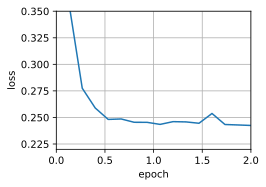

In [41]:
mini1_res = train_sgd(0.4, 100)

loss: 0.250, 0.048 sec/epoch


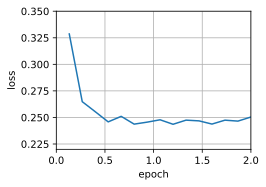

In [42]:
mini2_res = train_sgd(0.05, 10)

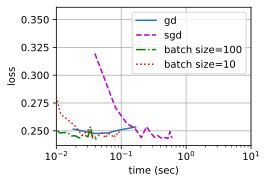

In [43]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

In [44]:
# Concise implementation
def train_concise(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    # initializes the parameters of a model given the function
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])

    n, timer = 0, d2l.Timer()

    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter), (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

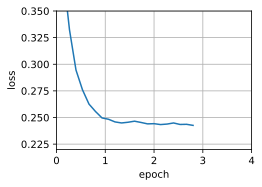

In [45]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise(trainer, {'lr': 0.01}, data_iter)

epoch 20, x1: -2.382563, x2: -0.158591


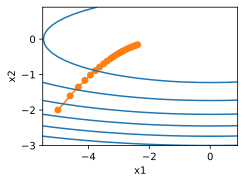

In [ ]:
# adagrad
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

loss: 0.243, 0.057 sec/epoch


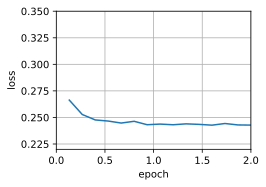

In [ ]:
# scratch implementation 
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

loss: 0.242, 0.053 sec/epoch


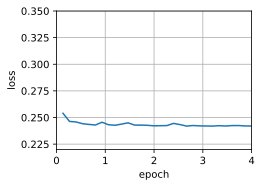

In [ ]:
# concise implementation
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

epoch 20, x1: -0.010599, x2: 0.000000


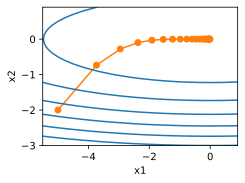

In [ ]:
# rms prop
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [ ]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.246, 0.062 sec/epoch


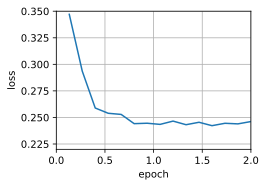

In [ ]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.246, 0.054 sec/epoch


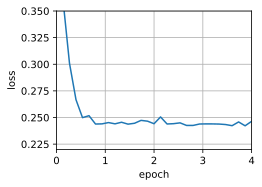

In [ ]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

In [ ]:
# adadelta

%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);


In [ ]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)